**Libraries**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import time
import random
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

# Data Preprocessing and Agumentation

In [2]:
train_transform= transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224,scale=(0.80,1.0)),
    transforms.ColorJitter(brightness=0.2,contrast=0.2),
    transforms.ToTensor()
])

test_transform= transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [3]:
Train_dataset=datasets.ImageFolder("/content/drive/MyDrive/Aerial Object classification CNN/train",transform=train_transform)
Test_dataset=datasets.ImageFolder("/content/drive/MyDrive/Aerial Object classification CNN/test",transform=test_transform)
valid_dataset=datasets.ImageFolder("/content/drive/MyDrive/Aerial Object classification CNN/valid",transform=test_transform)

train_data=DataLoader(Train_dataset,batch_size=32,shuffle=True)
test_data=DataLoader(Test_dataset,batch_size=32,shuffle=False)
valid_data=DataLoader(valid_dataset,batch_size=32,shuffle=False)

# Data Understanding

In [ ]:
def count_images(x):
  count=[0]*len(x.classes)
  for path,label in x.samples:
    count[label]=count[label]+1
  return dict(zip(x.classes,count))

In [ ]:
print("Train dataset",len(Train_dataset))
print("Train classes count: \n",count_images(Train_dataset))
print("")
print("Test dataset",len(Test_dataset))
print("Test classes count: \n",count_images(Test_dataset))
print("")
print("Validation dataset",len(valid_dataset))
print("Tvalidation classes count: \n",count_images(valid_dataset))

Train dataset 2662
Train classes count: 
 {'bird': 1414, 'drone': 1248}

Test dataset 215
Test classes count: 
 {'bird': 121, 'drone': 94}

Validation dataset 442
Tvalidation classes count: 
 {'bird': 217, 'drone': 225}


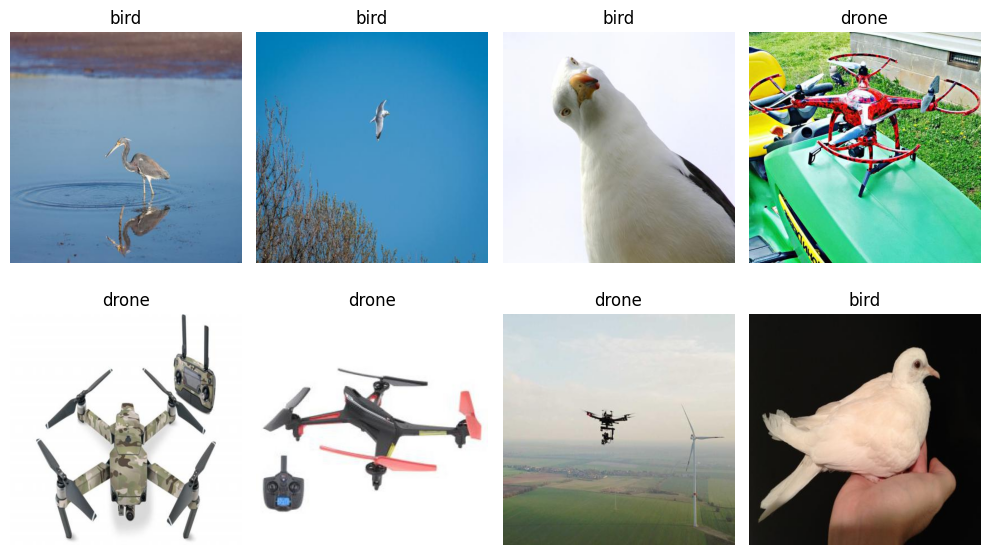

In [4]:
preview_data=datasets.ImageFolder("/content/drive/MyDrive/Aerial Object classification CNN/train",transform=transforms.ToTensor())

plt.figure(figsize=(10,6))

for i in range(8):
  img,label=preview_data[random.randint(0,len(preview_data)-1)]
  imgs=img.permute(1,2,0)
  plt.subplot(2,4,i+1)
  plt.imshow(imgs)
  plt.title(preview_data.classes[label])
  plt.axis('off')
plt.tight_layout()
plt.show()


# Custom CNN

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cuda


In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv=nn.Sequential(
        nn.Conv2d(3,16,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(16,32,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    self.fc=nn.Sequential(
        nn.Linear(32*56*56,128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128,1)
    )
  def forward(self,x):
    conv=self.conv(x)
    flat=conv.view(conv.size(0),-1)
    fc=self.fc(flat)
    return fc

## Training and Validation

In [ ]:
model=CNN().to(device)
criterion=nn.BCEWithLogitsLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

counter=0
patience=5
best_val_loss=float('inf')
checkpoint="best_model.pth"

In [ ]:
train_losses=[]
val_losses=[]
val_accuracies=[]

start_time=time.time()

epochs=10
for epoch in range(epochs):
  model.train()
  running_loss=0
  for img,labels in train_data:
    optimizer.zero_grad()
    img=img.to(device)
    labels=labels.unsqueeze(1).float().to(device)
    pred_labels=model(img)
    loss=criterion(pred_labels,labels)
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()

  train_loss=running_loss/len(train_data)
  train_losses.append(train_loss)
  print(f"Epoch{epoch+1}/{epochs}:")
  print("  Train Loss:",train_loss)

  model.eval()

  all_pred=[]
  all_label=[]
  val_loss=0.0

  with torch.no_grad():
    for img,label in valid_data:
      img=img.to(device)
      label=label.unsqueeze(1).float().to(device)
      logits=model(img)
      pred=torch.round(torch.sigmoid(logits))
      loss=criterion(logits,label)
      val_loss+=loss.item()
      all_pred.extend(pred.tolist())
      all_label.extend(label.tolist())
    val_loss=val_loss/len(valid_data)
    val_losses.append(val_loss)

  all_pred=[int(x[0]) for x in all_pred]
  all_label=[int(x[0]) for x in all_label]

  acc=accuracy_score(all_label,all_pred)
  conf=confusion_matrix(all_label,all_pred)
  class_rep=classification_report(all_label,all_pred)
  val_accuracies.append(acc)

  print("  Validation Loss:",val_loss)
  print("  Accuracy:",acc)
  print("  Confusion Matrix:\n",conf)
  print("  Classification Report:\n",class_rep)
  print("")

  if val_loss<best_val_loss:
    best_val_loss=val_loss
    counter=0
    torch.save(model.state_dict(),checkpoint)
  else:
    counter+=1
    if counter>=patience:
      print("Early stopping")
      break

end_time=time.time()
c_time=end_time-start_time
print("Training Time:",np.round(c_time/60,2))


Epoch1/10:
  Train Loss: 0.7205986895021939
  Validation Loss: 0.5514399473156247
  Accuracy: 0.7058823529411765
  Confusion Matrix:
 [[188  29]
 [101 124]]
  Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.87      0.74       217
           1       0.81      0.55      0.66       225

    accuracy                           0.71       442
   macro avg       0.73      0.71      0.70       442
weighted avg       0.73      0.71      0.70       442


Epoch2/10:
  Train Loss: 0.5634378673774856
  Validation Loss: 0.5236669523375375
  Accuracy: 0.7239819004524887
  Confusion Matrix:
 [[167  50]
 [ 72 153]]
  Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.77      0.73       217
           1       0.75      0.68      0.71       225

    accuracy                           0.72       442
   macro avg       0.73      0.72      0.72       442
weighted avg       0.73      0.72 

## EDA

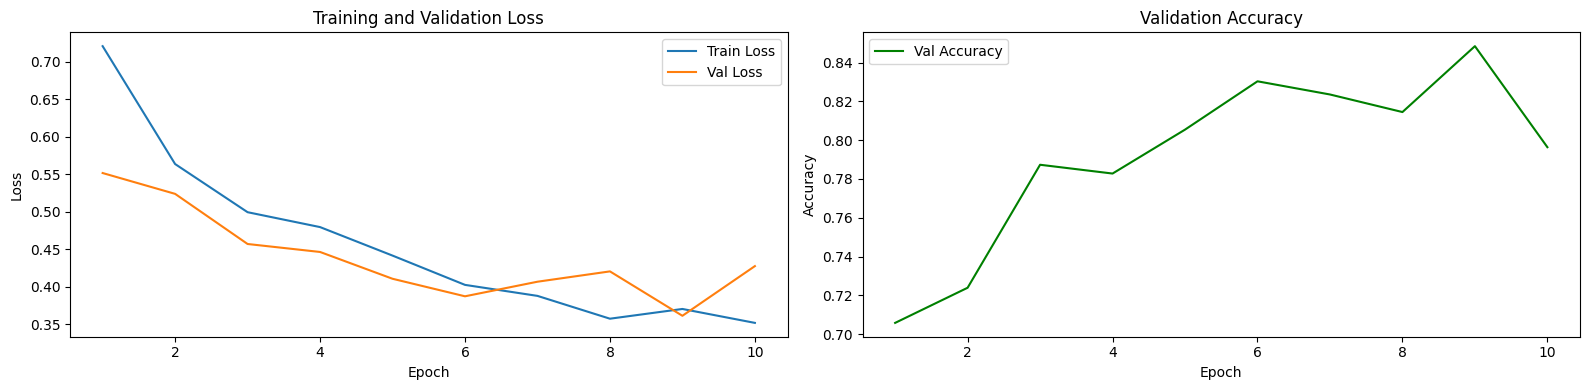

In [ ]:
epoch_range=range(1,epochs+1)

plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
plt.plot(epoch_range,train_losses,label="Train Loss")
plt.plot(epoch_range,val_losses,label="Val Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epoch_range,val_accuracies,label="Val Accuracy",color="green")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Testing

In [ ]:
model.eval()

y_true=[]
y_pred=[]

with torch.no_grad():
  for imgs,labels in test_data:
    imgs=imgs.to(device)
    labels=labels.unsqueeze(1).float().to(device)
    logits=model(imgs)
    pred=torch.round(torch.sigmoid(logits))
    y_true.extend(labels.tolist())
    y_pred.extend(pred.tolist())

In [ ]:
y_trues=[int(x[0]) for x in y_true]
y_preds=[int(x[0]) for x in y_pred]

In [ ]:
acc=accuracy_score(y_trues,y_preds)
prec=precision_score(y_trues,y_preds)
rec=recall_score(y_trues,y_preds)
conf=confusion_matrix(y_trues,y_preds)
class_rep=classification_report(y_trues,y_preds)

In [ ]:
print('Accuracy:',acc ,'\n')
print('Precision:',prec, '\n')
print('Recall:',rec, '\n')
print('Confusion Matrix: \n',conf,'\n' )
print('Classification Report: \n',class_rep)

Accuracy: 0.8232558139534883 

Precision: 0.8255813953488372 

Recall: 0.7553191489361702 

Confusion Matrix: 
 [[106  15]
 [ 23  71]] 

Classification Report: 
               precision    recall  f1-score   support

           0       0.82      0.88      0.85       121
           1       0.83      0.76      0.79        94

    accuracy                           0.82       215
   macro avg       0.82      0.82      0.82       215
weighted avg       0.82      0.82      0.82       215



# Pre-Trained Models

## Model Imports

In [6]:
def resnet50_model():
  model=models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

  model.fc=nn.Linear(model.fc.in_features,1)

  for name, param in model.named_parameters():
    if 'layer4' in name:
      param.requires_grad=True
    else:
      param.requires_grad=False

  return model

In [7]:
def mobilenetv2_model():
  model=models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

  model.classifier[1]=nn.Linear(model.last_channel,1)

  for name, param in model.named_parameters():
    if 'features.17' in name:
      param.requires_grad=True
    else:
      param.requires_grad=False

  return model

In [8]:
def efficientnetb0_model():
  model=models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

  model.classifier[1]=nn.Linear(model.classifier[1].in_features,1)

  for name, param in model.named_parameters():
    if 'features.6' in name:
      param.requires_grad=True
    else:
      param.requires_grad=False

  return model

## Resnet 50

### Training and Validation

In [9]:
resnet=resnet50_model().to(device)
criterion=nn.BCEWithLogitsLoss()
optimizer=optim.Adam(filter(lambda p:p.requires_grad, resnet.parameters()),lr=0.001)

r_train_losses=[]
r_val_losses=[]
r_val_accuracies=[]

counter=0
patience=5
best_val_loss=float('inf')
checkpoint="r_best_model.pth"

start_time=time.time()

epochs=8
for epoch in range(epochs):
  resnet.train()
  running_loss=0
  for img,labels in train_data:
    optimizer.zero_grad()
    img=img.to(device)
    labels=labels.unsqueeze(1).float().to(device)
    pred_labels=resnet(img)
    loss=criterion(pred_labels,labels)
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()

  train_loss=running_loss/len(train_data)
  r_train_losses.append(train_loss)
  print(f"Epoch{epoch+1}/{epochs}:")
  print("  Train Loss:",train_loss)

  resnet.eval()

  all_pred=[]
  all_label=[]
  val_loss=0.0

  with torch.no_grad():
    for img,label in valid_data:
      img=img.to(device)
      label=label.unsqueeze(1).float().to(device)
      logits=resnet(img)
      pred=torch.round(torch.sigmoid(logits))
      loss=criterion(logits,label)
      val_loss+=loss.item()
      all_pred.extend(pred.tolist())
      all_label.extend(label.tolist())
    val_loss=val_loss/len(valid_data)
    r_val_losses.append(val_loss)

  all_pred=[int(x[0]) for x in all_pred]
  all_label=[int(x[0]) for x in all_label]

  acc=accuracy_score(all_label,all_pred)
  conf=confusion_matrix(all_label,all_pred)
  class_rep=classification_report(all_label,all_pred)
  r_val_accuracies.append(acc)

  print("  Validation Loss:",val_loss)
  print("  Accuracy:",acc)
  print("  Confusion Matrix:\n",conf)
  print("  Classification Report:\n",class_rep)
  print("")

  if val_loss<best_val_loss:
    best_val_loss=val_loss
    counter=0
    torch.save(resnet.state_dict(),checkpoint)
  else:
    counter+=1
    if counter>=patience:
      print("Early stopping")
      break

end_time=time.time()
r_time=end_time-start_time
print("Training Time: ",r_time//60,":",r_time%60)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 202MB/s]


Epoch1/8:
  Train Loss: 0.14785619659371496
  Validation Loss: 0.06880174138184104
  Accuracy: 0.9864253393665159
  Confusion Matrix:
 [[215   2]
 [  4 221]]
  Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       217
           1       0.99      0.98      0.99       225

    accuracy                           0.99       442
   macro avg       0.99      0.99      0.99       442
weighted avg       0.99      0.99      0.99       442


Epoch2/8:
  Train Loss: 0.05554382075067787
  Validation Loss: 0.031025097451804737
  Accuracy: 0.9909502262443439
  Confusion Matrix:
 [[216   1]
 [  3 222]]
  Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       217
           1       1.00      0.99      0.99       225

    accuracy                           0.99       442
   macro avg       0.99      0.99      0.99       442
weighted avg       0.99      0.

### EDA

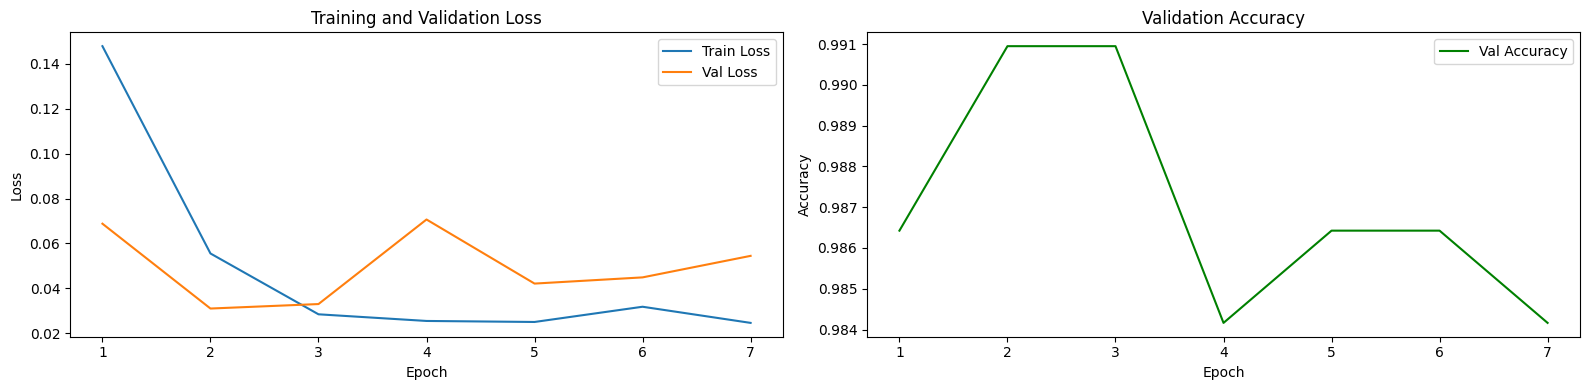

In [11]:
epoch_range=range(1,epochs)

plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
plt.plot(epoch_range,r_train_losses,label="Train Loss")
plt.plot(epoch_range,r_val_losses,label="Val Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epoch_range,r_val_accuracies,label="Val Accuracy",color="green")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Testing

In [12]:
resnet.eval()

y_true=[]
y_pred=[]

with torch.no_grad():
  for imgs,labels in test_data:
    imgs=imgs.to(device)
    labels=labels.unsqueeze(1).float().to(device)
    logits=resnet(imgs)
    pred=torch.round(torch.sigmoid(logits))
    y_true.extend(labels.tolist())
    y_pred.extend(pred.tolist())

y_trues=[int(x[0]) for x in y_true]
y_preds=[int(x[0]) for x in y_pred]

acc=accuracy_score(y_trues,y_preds)
prec=precision_score(y_trues,y_preds)
rec=recall_score(y_trues,y_preds)
conf=confusion_matrix(y_trues,y_preds)
class_rep=classification_report(y_trues,y_preds)

print('Accuracy:',acc ,'\n')
print('Precision:',prec, '\n')
print('Recall:',rec, '\n')
print('Confusion Matrix: \n',conf,'\n' )
print('Classification Report: \n',class_rep)

Accuracy: 0.9906976744186047 

Precision: 1.0 

Recall: 0.9787234042553191 

Confusion Matrix: 
 [[121   0]
 [  2  92]] 

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       121
           1       1.00      0.98      0.99        94

    accuracy                           0.99       215
   macro avg       0.99      0.99      0.99       215
weighted avg       0.99      0.99      0.99       215



## Mobilenet V2

### Training and Validation

In [ ]:
mobilenet=mobilenetv2_model().to(device)
criterion=nn.BCEWithLogitsLoss()
optimizer=optim.Adam(filter(lambda p:p.requires_grad, mobilenet.parameters()),lr=0.001)

m_train_losses=[]
m_val_losses=[]
m_val_accuracies=[]

counter=0
patience=5
best_val_loss=float('inf')
checkpoint="m_best_model.pth"

start_time=time.time()

epochs=10
for epoch in range(epochs):
  mobilenet.train()
  running_loss=0
  for img,labels in train_data:
    optimizer.zero_grad()
    img=img.to(device)
    labels=labels.unsqueeze(1).float().to(device)
    pred_labels=mobilenet(img)
    loss=criterion(pred_labels,labels)
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()

  train_loss=running_loss/len(train_data)
  m_train_losses.append(train_loss)
  print(f"Epoch{epoch+1}/{epochs}:")
  print("  Train Loss:",train_loss)

  mobilenet.eval()

  all_pred=[]
  all_label=[]
  val_loss=0.0

  with torch.no_grad():
    for img,label in valid_data:
      img=img.to(device)
      label=label.unsqueeze(1).float().to(device)
      logits=mobilenet(img)
      pred=torch.round(torch.sigmoid(logits))
      loss=criterion(logits,label)
      val_loss+=loss.item()
      all_pred.extend(pred.tolist())
      all_label.extend(label.tolist())
    val_loss=val_loss/len(valid_data)
    m_val_losses.append(val_loss)

  all_pred=[int(x[0]) for x in all_pred]
  all_label=[int(x[0]) for x in all_label]

  acc=accuracy_score(all_label,all_pred)
  conf=confusion_matrix(all_label,all_pred)
  class_rep=classification_report(all_label,all_pred)
  m_val_accuracies.append(acc)

  print("  Validation Loss:",val_loss)
  print("  Accuracy:",acc)
  print("  Confusion Matrix:\n",conf)
  print("  Classification Report:\n",class_rep)
  print("")

  if val_loss<best_val_loss:
    best_val_loss=val_loss
    counter=0
    torch.save(mobilenet.state_dict(),checkpoint)
  else:
    counter+=1
    if counter>=patience:
      print("Early stopping")
      break

end_time=time.time()
m_time=end_time-start_time
print("Training Time: ",m_time//60,":",m_time%60)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 69.7MB/s]


Epoch1/10:
  Train Loss: 0.26657756187376525
  Validation Loss: 0.14829364206109727
  Accuracy: 0.9638009049773756
  Confusion Matrix:
 [[203  14]
 [  2 223]]
  Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.94      0.96       217
           1       0.94      0.99      0.97       225

    accuracy                           0.96       442
   macro avg       0.97      0.96      0.96       442
weighted avg       0.97      0.96      0.96       442


Epoch2/10:
  Train Loss: 0.1341040421809469
  Validation Loss: 0.11450215562113694
  Accuracy: 0.9773755656108597
  Confusion Matrix:
 [[210   7]
 [  3 222]]
  Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       217
           1       0.97      0.99      0.98       225

    accuracy                           0.98       442
   macro avg       0.98      0.98      0.98       442
weighted avg       0.98      0.

### EDA

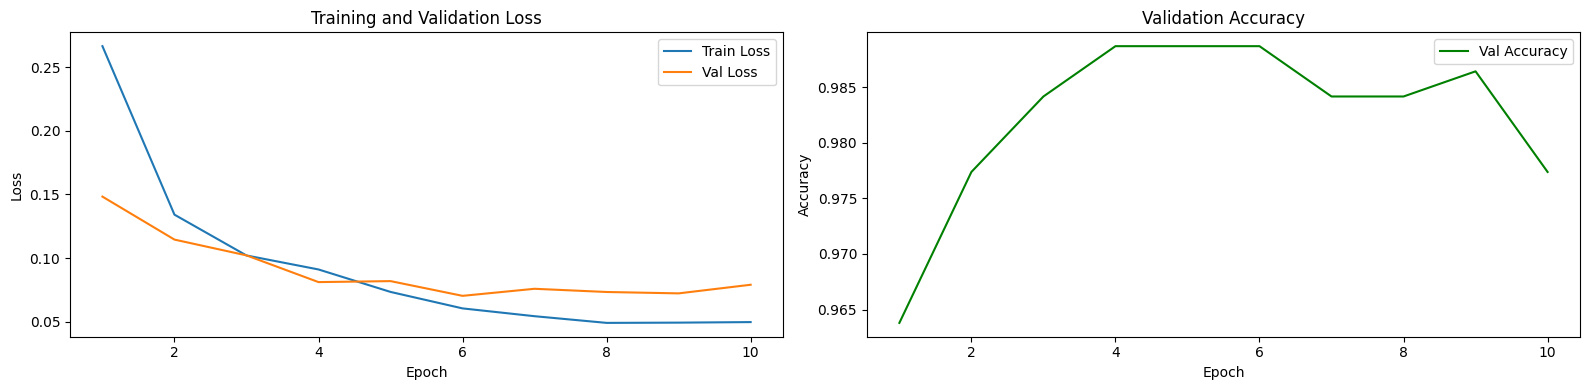

In [ ]:
epoch_range=range(1,epochs+1)

plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
plt.plot(epoch_range,m_train_losses,label="Train Loss")
plt.plot(epoch_range,m_val_losses,label="Val Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epoch_range,m_val_accuracies,label="Val Accuracy",color="green")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Testing

In [ ]:
mobilenet.eval()

y_true=[]
y_pred=[]

with torch.no_grad():
  for imgs,labels in test_data:
    imgs=imgs.to(device)
    labels=labels.unsqueeze(1).float().to(device)
    logits=mobilenet(imgs)
    pred=torch.round(torch.sigmoid(logits))
    y_true.extend(labels.tolist())
    y_pred.extend(pred.tolist())

y_trues=[int(x[0]) for x in y_true]
y_preds=[int(x[0]) for x in y_pred]

acc=accuracy_score(y_trues,y_preds)
prec=precision_score(y_trues,y_preds)
rec=recall_score(y_trues,y_preds)
conf=confusion_matrix(y_trues,y_preds)
class_rep=classification_report(y_trues,y_preds)

print('Accuracy:',acc ,'\n')
print('Precision:',prec, '\n')
print('Recall:',rec, '\n')
print('Confusion Matrix: \n',conf,'\n' )
print('Classification Report: \n',class_rep)

Accuracy: 0.9813953488372092 

Precision: 0.9891304347826086 

Recall: 0.9680851063829787 

Confusion Matrix: 
 [[120   1]
 [  3  91]] 

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       121
           1       0.99      0.97      0.98        94

    accuracy                           0.98       215
   macro avg       0.98      0.98      0.98       215
weighted avg       0.98      0.98      0.98       215



## Efficientnet B0

### Training and Validation

In [ ]:
efficientnet= efficientnetb0_model().to(device)
criterion=nn.BCEWithLogitsLoss()
optimizer=optim.Adam(filter(lambda p:p.requires_grad, efficientnet.parameters()),lr=0.001)

e_train_losses=[]
e_val_losses=[]
e_val_accuracies=[]

counter=0
patience=5
best_val_loss=float('inf')
checkpoint="e_best_model.pth"

start_time=time.time()

epochs=10
for epoch in range(epochs):
  efficientnet.train()
  running_loss=0
  for img,labels in train_data:
    optimizer.zero_grad()
    img=img.to(device)
    labels=labels.unsqueeze(1).float().to(device)
    pred_labels=efficientnet(img)
    loss=criterion(pred_labels,labels)
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()

  train_loss=running_loss/len(train_data)
  e_train_losses.append(train_loss)
  print(f"Epoch{epoch+1}/{epochs}:")
  print("  Train Loss:",train_loss)

  efficientnet.eval()

  all_pred=[]
  all_label=[]
  val_loss=0.0

  with torch.no_grad():
    for img,label in valid_data:
      img=img.to(device)
      label=label.unsqueeze(1).float().to(device)
      logits=efficientnet(img)
      pred=torch.round(torch.sigmoid(logits))
      loss=criterion(logits,label)
      val_loss+=loss.item()
      all_pred.extend(pred.tolist())
      all_label.extend(label.tolist())
    val_loss=val_loss/len(valid_data)
    e_val_losses.append(val_loss)

  all_pred=[int(x[0]) for x in all_pred]
  all_label=[int(x[0]) for x in all_label]

  acc=accuracy_score(all_label,all_pred)
  conf=confusion_matrix(all_label,all_pred)
  class_rep=classification_report(all_label,all_pred)
  e_val_accuracies.append(acc)

  print("  Validation Loss:",val_loss)
  print("  Accuracy:",acc)
  print("  Confusion Matrix:\n",conf)
  print("  Classification Report:\n",class_rep)
  print("")

  if val_loss<best_val_loss:
    best_val_loss=val_loss
    counter=0
    torch.save(efficientnet.state_dict(),checkpoint)
  else:
    counter+=1
    if counter>=patience:
      print("Early stopping")
      break

end_time=time.time()
e_time=end_time-start_time
print("Training Time: ",e_time//60,":",e_time%60)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 118MB/s] 


Epoch1/10:
  Train Loss: 0.286160963720509
  Validation Loss: 0.16489679366350174
  Accuracy: 0.9615384615384616
  Confusion Matrix:
 [[215   2]
 [ 15 210]]
  Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96       217
           1       0.99      0.93      0.96       225

    accuracy                           0.96       442
   macro avg       0.96      0.96      0.96       442
weighted avg       0.96      0.96      0.96       442


Epoch2/10:
  Train Loss: 0.14362126828304358
  Validation Loss: 0.18687431061906473
  Accuracy: 0.9276018099547512
  Confusion Matrix:
 [[186  31]
 [  1 224]]
  Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92       217
           1       0.88      1.00      0.93       225

    accuracy                           0.93       442
   macro avg       0.94      0.93      0.93       442
weighted avg       0.94      0.9

### EDA

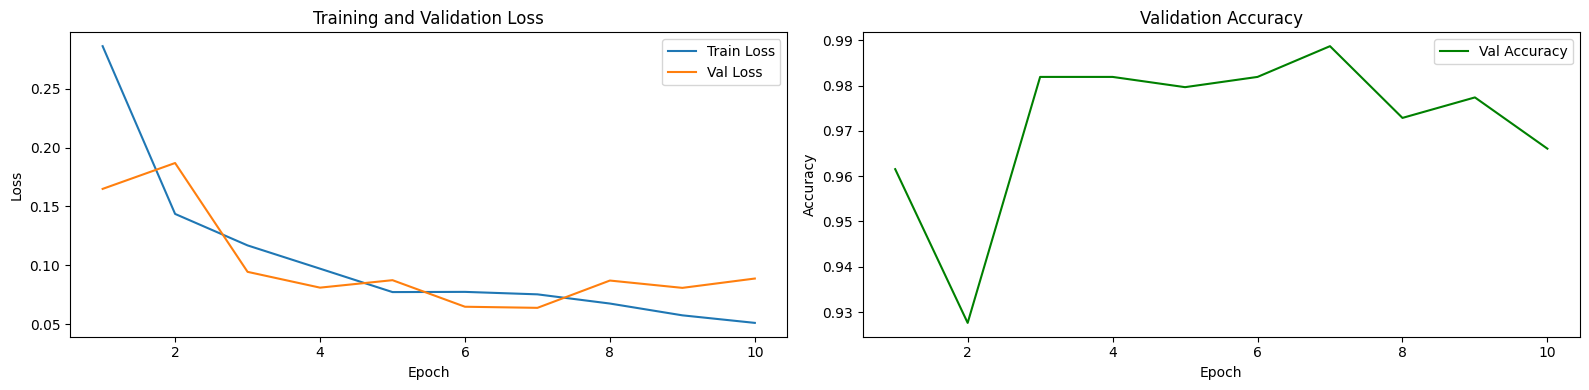

In [ ]:
epoch_range=range(1,epochs+1)

plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
plt.plot(epoch_range,e_train_losses,label="Train Loss")
plt.plot(epoch_range,e_val_losses,label="Val Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epoch_range,e_val_accuracies,label="Val Accuracy",color="green")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Testing

In [ ]:
efficientnet.eval()

y_true=[]
y_pred=[]

with torch.no_grad():
  for imgs,labels in test_data:
    imgs=imgs.to(device)
    labels=labels.unsqueeze(1).float().to(device)
    logits=efficientnet(imgs)
    pred=torch.round(torch.sigmoid(logits))
    y_true.extend(labels.tolist())
    y_pred.extend(pred.tolist())

y_trues=[int(x[0]) for x in y_true]
y_preds=[int(x[0]) for x in y_pred]

acc=accuracy_score(y_trues,y_preds)
prec=precision_score(y_trues,y_preds)
rec=recall_score(y_trues,y_preds)
conf=confusion_matrix(y_trues,y_preds)
class_rep=classification_report(y_trues,y_preds)

print('Accuracy:',acc ,'\n')
print('Precision:',prec, '\n')
print('Recall:',rec, '\n')
print('Confusion Matrix: \n',conf,'\n' )
print('Classification Report: \n',class_rep)

Accuracy: 0.9813953488372092 

Precision: 0.9787234042553191 

Recall: 0.9787234042553191 

Confusion Matrix: 
 [[119   2]
 [  2  92]] 

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       121
           1       0.98      0.98      0.98        94

    accuracy                           0.98       215
   macro avg       0.98      0.98      0.98       215
weighted avg       0.98      0.98      0.98       215

